In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *
import segmentation_models_pytorch as smp


from pathlib import Path
import random

In [2]:
import torch
torch.cuda.set_device(0)

In [3]:
%matplotlib inline
import numpy as np

In [4]:
number_of_the_seed = 2020

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
path = Path("./")
path_images = path/"1. Images/1. Training Set"
path_labels = path/"2. Groundtruths/1. Training Set"

In [6]:
get_y_fn = lambda x: Path(str(x).replace("1. Images","2. Groundtruths"))

In [7]:
codes = np.loadtxt('codes.txt', dtype=str)

In [8]:
monitor_training="dice_multi"
comp_training=np.greater

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=5

In [9]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    VerticalFlip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [10]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Flip(p=0.5),
                        VerticalFlip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=180),GridDistortion(),CLAHE(),
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [11]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 4
        mask[mask==255]=1
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

In [12]:
path_manual_img = path_images
path_manual_lbl = path_labels

1. Images/1. Training Set/mmac_task_2_train_LC_0007.png


<Axes: >

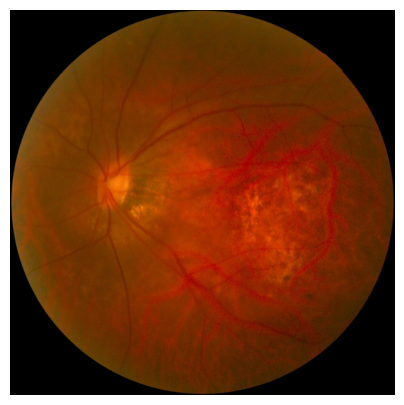

In [13]:
fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

# open and show image
img_f = fnames_manual[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [14]:
print(get_y_fn(img_f))

2. Groundtruths/1. Training Set/mmac_task_2_train_LC_0007.png


<Axes: >

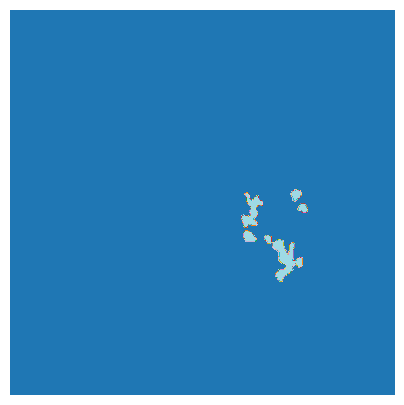

In [15]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [16]:
bs = 4

In [17]:
codes

array(['BG', 'FG'], dtype='<U2')

In [18]:
trainDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((800,800)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

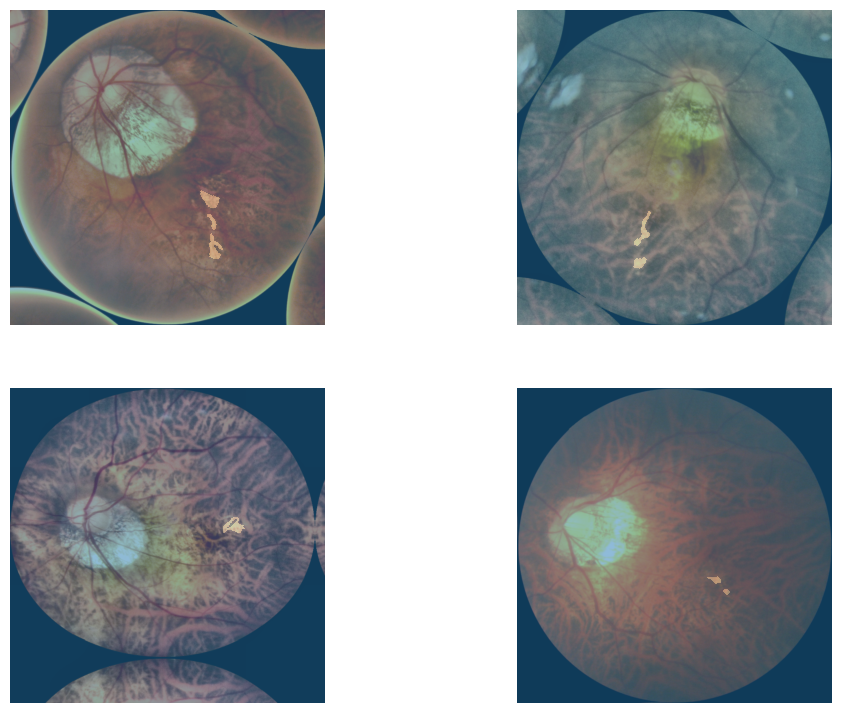

In [19]:
dlsTrain = trainDB.dataloaders(path_images,bs=bs)

dlsTrain.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [20]:
model = smp.UnetPlusPlus(
    encoder_name="timm-efficientnet-b3",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=5,                      # model output channels (number of classes in your dataset)
)

In [21]:
learn = Learner(dlsTrain,model,metrics=[DiceMulti()]).to_fp16()

epoch,train_loss,valid_loss,dice_multi,time
0,2.097963,1.837405,0.069610,00:07
1,2.000483,1.814301,0.067127,00:06
2,1.903969,1.722091,0.066770,00:06
3,1.805369,1.592711,0.074086,00:06
4,1.694136,1.379055,0.108125,00:06
5,1.573230,1.191664,0.142923,00:06
6,1.444091,1.015281,0.185601,00:06
7,1.305055,0.746944,0.197251,00:06
8,1.164372,0.637125,0.199072,00:06
9,1.022307,0.503422,0.249557,00:06


Better model found at epoch 0 with dice_multi value: 0.06961005093604627.


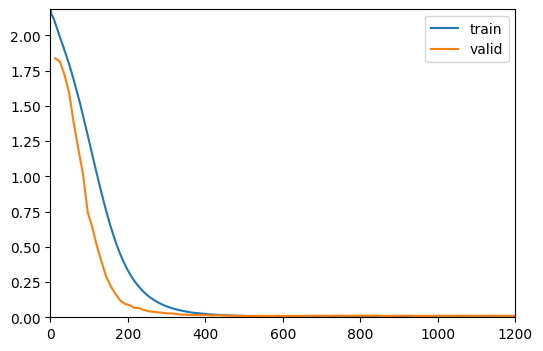

Better model found at epoch 3 with dice_multi value: 0.07408646941719443.
Better model found at epoch 4 with dice_multi value: 0.10812492615342154.
Better model found at epoch 5 with dice_multi value: 0.14292295146555578.
Better model found at epoch 6 with dice_multi value: 0.18560107483619712.
Better model found at epoch 7 with dice_multi value: 0.19725128464902314.
Better model found at epoch 8 with dice_multi value: 0.19907196208629496.
Better model found at epoch 9 with dice_multi value: 0.24955727400136452.
Better model found at epoch 10 with dice_multi value: 0.2496152616800894.
Better model found at epoch 11 with dice_multi value: 0.24963059102111404.
Better model found at epoch 12 with dice_multi value: 0.33283935149436517.
Better model found at epoch 13 with dice_multi value: 0.4992675810379674.
Better model found at epoch 30 with dice_multi value: 0.5030824103608482.
Better model found at epoch 34 with dice_multi value: 0.6204554760670025.
Better model found at epoch 36 with 

In [22]:
fname="unetplusplus-efficientnet"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    # EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(100, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [23]:
learn1 = Learner(dlsTrain,model)

In [27]:
learn1.load("unetplusplus-efficientnet")

/home/joheras/.conda/envs/python38/lib/python3.8/site-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [34]:
aux=learn.model
aux=aux.cpu()

torch.save(aux,'deeplab-lacker.pth')

In [3]:

aux1 = torch.load('deeplab-lacker.pth')

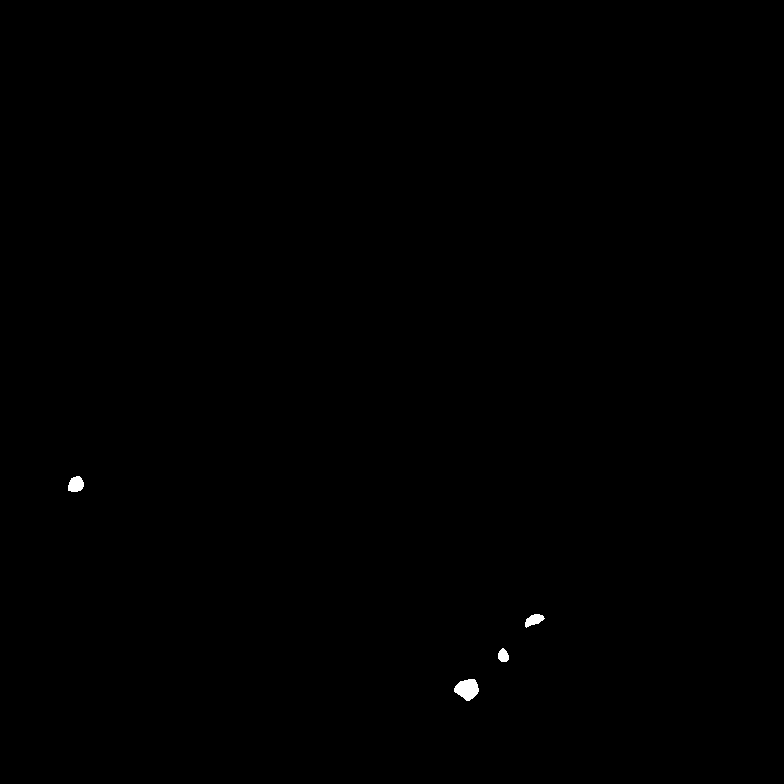

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
aux.eval()

import torchvision.transforms as transforms
def transform_image(image):
    my_transforms = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image_aux = image
    return my_transforms(image_aux).unsqueeze(0).to(device)

image = Image.open('../3. Fuchs Spot/1. Images/1. Training Set/mmac_task_2_train_FS_0009.png')
image = transforms.Resize((784,784))(image)
tensor = transform_image(image=image)
aux.to(device)
with torch.no_grad():
    outputs = aux(tensor)

outputs = torch.argmax(outputs,1)
mask = np.array(outputs.cpu())
mask[mask==1]=255
mask=np.reshape(mask,(784,784))
maskShow = Image.fromarray(mask.astype('uint8'))
maskShow

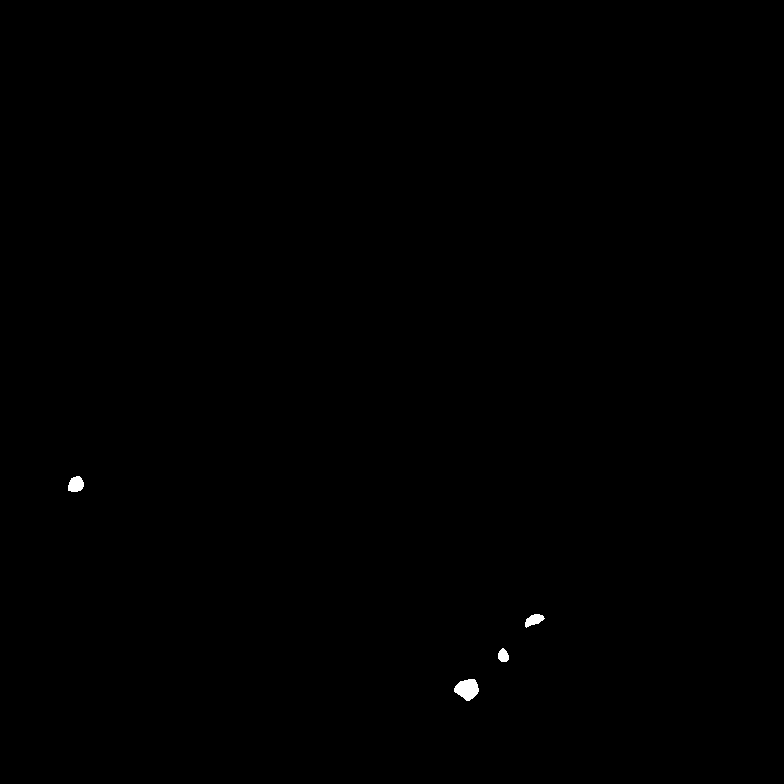

In [10]:
import cv2
import PIL.Image
if not hasattr(PIL.Image, 'Resampling'):  # Pillow<9.0
    PIL.Image.Resampling = PIL.Image
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
aux1.eval()

import torchvision.transforms as transforms
def transform_image(image):
    my_transforms = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image_aux = image
    return my_transforms(image_aux).unsqueeze(0).to(device)

image = PIL.Image.fromarray(cv2.cvtColor(input_image,cv2.COLOR_BGR2RGB))

image = transforms.Resize((784,784))(image)
tensor = transform_image(image=image)
aux1.to(device)
with torch.no_grad():
    outputs = aux1(tensor)

outputs = torch.argmax(outputs,1)
mask = np.array(outputs.cpu())
mask[mask==1]=255
mask=np.reshape(mask,(784,784))
maskShow = Image.fromarray(mask.astype('uint8'))
maskShow